HSE, Applied Time Series Forecasitng , Fall2024

<font color="green"> Lesson #5: TS Foreasting using ARIMA Models </font>

<span style="color:black; font-size: 12pt"></span>

Alexey Romanenko,
<font color="blue">alexromsput@gmail.com</font>

**Key words:**
    - stationary TS, ARMA, ARIMA, ARMAX, SARIMAX, autocorrelcation function,  partial autocorrelation function, exogenious variables,
**Your feedback:**  please provide you feedback  <a href="https://forms.gle/bEV5iwmTqdM9rUoy8"> here </a>

In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import stattools
from copy import deepcopy

# don't forget to upload utils file to the colab session
from utils import qualityMAPE, qualityRMSE
import warnings
warnings.filterwarnings('ignore')

pd.options.plotting.backend = "plotly"

# setting of the plotting style, registers pandas date converters for matplotlib and the default figure size
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
# pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(25, 5))
sns.mpl.rc("font", size=14)

# ARIMA Parameters
**Questions**
  * How to make TS stationary?
  * Write down formula that describes how the tranformed ts will look like (use lag operator $\bf B$).

**Answer**
$${\bf(1-B)^d(1-B^s)^D} {\bf BoxCox_{\lambda}} (y_t)$$
where $s~-$ seasonality period







## ARIMA model for non-stationary time series
In order to make ts stationary we apply trend ${\bf(1-\bf B)}$ differencing $d$ times and seasonal ${\bf(1-B^s)}$ differencing $D$ times.


**Main hypothesys**: exists $d$, $D$, $\lambda$ such that
  
  * $$ {\bf(1-B)^d(1-B^s)^D} {\bf BoxCox_{\lambda}} (y_t)~- \text{ stationary} $$


Final ts model:
* Lets denote: ${\bf BoxCox_{\lambda}} (y_t) = z_t$
* classic form:
$$\color{red}{\underbrace{\bf(1-B)^d(1-B^s)^D}\limits_{I}}z_t = \underbrace{c+\sum_{i=1}^{p}}\limits_{AR} \alpha_iz_{t-i}+\underbrace{\sum_{j=1}^{q}}\limits_{MA} \beta_j\varepsilon_{t-j}+\varepsilon_t$$

* or in canonical form:

$$\underbrace{\phi\left({\bf B}\right)}\limits_{AR}\color{red}{\underbrace{\bf(1-B)^d(1-B^s)^D}\limits_{I}}(z_t-\mu) = \underbrace{\theta\left(\bf B\right)}\limits_{MA}\varepsilon_t.$$

* $\varepsilon_t$- random variable from $N(0, \sigma^2)$, $E\varepsilon_t=0, ~E\varepsilon_i\varepsilon_j=0$

# Fitting Parameters of ARIMA model

Classic form of ARIMA model implies that there are some seasonal Autoregressive Components and seasonal Moving Average Components


$${\bf(1-B)^{\color{red}{d}}(1-B^s)^{\color{red}D}}z_t = \underbrace{c+\sum_{i=1}^{\color{red}p}}\limits_{AR} \alpha_iz_{t-i}+\underbrace{\sum_{j=1}^{\color{red}q}}\limits_{MA} \beta_j\varepsilon_{t-j}+\underbrace{\sum_{l=1}^{\color{red}P}}\limits_{seasonal~AR} \delta_lz_{t-\color{red}{s\cdot l}}+\underbrace{\sum_{m=1}^{\color{red}Q}}\limits_{seasonal~MA} \omega_m\varepsilon_{t-\color{red}{s*m}}+\varepsilon_t$$


Classic ARIMA model contains 6 (hyper)parameters:
$$ARIMA(p, d, q)\times(P, D, Q)_s$$
where

 - $p~-$ is a number of non-seasonal AR components
 - $q~-$ is a number of non-seasonal MA components
 - $d~-$ is a number of trend-differencing applied to make ts stationary
 - $P~-$ is a number of seasonal AR components
 - $Q~-$ is a number of seasonal MA components
 - $D~-$ is a number of seasonal-differencing to make ts stationary

In [11]:
import requests
from io import StringIO

url = 'https://raw.githubusercontent.com/aromanenko/ATSF/33b78c9be63831567f8036ad40c5859e824d30f7/data/monthly-wage.csv'
response = requests.get(url, verify=True)

ts_wage = pd.read_csv(
        StringIO(response.text),
        sep=';',
        decimal='.',
        parse_dates=True,
        index_col='Month'
    )

ts_wage.index.names=['Timestamp']
ts_wage.plot().update_layout(height=350, width=1300).show()

## Fitting of $\lambda$, $d$, $D$ parameters

In [12]:
ts_wage_boxcox = deepcopy(ts_wage)
# find optimal lambda
print('optimal lambda:', stats.boxcox(ts_wage['Real wage'])[1])

# Box_Cox transformation (see lesson 4 for details)
ts_wage_boxcox['wage_boxcox'] = np.log(ts_wage)
# ts_wage_boxcox['wage_boxcox'].plot()


# seasonal differencing
p = 12
sdiff_ts_wage_boxcox = (ts_wage_boxcox['wage_boxcox'] - ts_wage_boxcox['wage_boxcox'].shift(p))[p:]
# sdiff_ts_wage_boxcox.plot()

# trend differencing
diff_sdiff_ts_wage_boxcox = (sdiff_ts_wage_boxcox  - sdiff_ts_wage_boxcox .shift(1))[1:]
diff_sdiff_ts_wage_boxcox.plot()

# Kwiatkowski–Phillips–Schmidt–Shin
kpss_stat= stattools.kpss(np.array(diff_sdiff_ts_wage_boxcox))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' %
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

# Augmented Dickey-Fuller unit root test
df_stat = stattools.adfuller(np.array(diff_sdiff_ts_wage_boxcox))
print('The Augmented Dickey-Fuller test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ncritical values: %s' %
      (df_stat[0], df_stat[1], df_stat[2], df_stat[4]))


optimal lambda: 0.1268261328743817
The KPSS test statistic 0.024144, 
pvalue: 0.10 
maximal Lag: 7 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The Augmented Dickey-Fuller test statistic -4.434243, 
pvalue: 0.00 
maximal Lag: 15 
critical values: {'1%': -3.4557539868570775, '5%': -2.8727214497041422, '10%': -2.572728476331361}


In [13]:
# Let's train our first ARMA(p,q) model
arma_mod00 = sm.tsa.ARIMA(diff_sdiff_ts_wage_boxcox, order=(0,0,0)).fit()
print(arma_mod00.summary())

                               SARIMAX Results                                
Dep. Variable:            wage_boxcox   No. Observations:                  276
Model:                          ARIMA   Log Likelihood                 490.277
Date:                Wed, 26 Feb 2025   AIC                           -976.554
Time:                        00:18:08   BIC                           -969.313
Sample:                    02-01-1994   HQIC                          -973.648
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.002      0.101      0.920      -0.005       0.005
sigma2         0.0017   3.91e-05     42.871      0.000       0.002       0.002
Ljung-Box (L1) (Q):                  19.97   Jarque-

**Questions**
  * What should be done to forecast original wage ts?

In [14]:
# draw ARMA forecast and ts
pd.DataFrame(arma_mod00.get_prediction().predicted_mean['2000-01-01':]).merge(diff_sdiff_ts_wage_boxcox, how='left', right_index = True, left_index = True).plot().update_layout(height=350, width=1300).show()

In [15]:
# Let's train our first ARIMA (p, d, q)x(P, D, Q, s) model
arima_010_010 = sm.tsa.SARIMAX(endog = ts_wage_boxcox['wage_boxcox'], order=(0, 1, 0), seasonal_order = (0,1,0,12)).fit()
print(arima_010_010.summary())

#  static predictions = one-step-ahead forecast
predict = arima_010_010.get_prediction()
forecast = pd.DataFrame(predict.predicted_mean).rename(columns = {'predicted_mean':'static_forecast'})
forecast_ci = predict.conf_int().rename(columns = {'lower wage_boxcox':'l_ci_st',	'upper wage_boxcox':'u_ci_st'}) # confidence interval


start_dt = '2000-01-01'

#  Dynamic predictions = n-step-ahead forecast
predict_dy = arima_010_010.get_prediction(dynamic=start_dt)
forecast_dy = pd.DataFrame(predict_dy.predicted_mean).rename(columns = {'predicted_mean':'dynamic_forecast'})
forecast_dy_ci = predict_dy.conf_int().rename(columns = {'lower wage_boxcox':'l_ci_dy',	'upper wage_boxcox':'u_ci_dy'}) # confidence interval


# Plot data points and predictions
ts_wage_boxcox.loc[start_dt:, ['wage_boxcox']].merge(
     forecast[start_dt:],
      how = 'left', left_index = True, right_index = True
      ).merge(
          forecast_dy[start_dt:],
          how = 'left', left_index = True, right_index = True
      ).merge(
        forecast_ci,
        how = 'left', left_index = True, right_index = True
      ).merge(
        forecast_dy_ci,
        how = 'left', left_index = True, right_index = True
      ).plot().update_layout(height=350, width=1300).show()


                                     SARIMAX Results                                      
Dep. Variable:                        wage_boxcox   No. Observations:                  289
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 490.272
Date:                            Wed, 26 Feb 2025   AIC                           -978.543
Time:                                    00:18:12   BIC                           -974.923
Sample:                                01-01-1993   HQIC                          -977.090
                                     - 01-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0017   3.91e-05     42.898      0.000       0.002       0.002
Ljung-Box (L1) (Q):                

In [16]:
def draw_arima_forecast(ts, arima_model, start_dt=0, end_dt=-1):
  predict = arima_model.get_prediction()
  forecast = pd.DataFrame(predict.predicted_mean).rename(columns = {'predicted_mean':'static_forecast'})
  forecast_ci = predict.conf_int().rename(columns = {'lower wage_boxcox':'l_ci_st',	'upper wage_boxcox':'u_ci_st'}) # confidence interval

  #  Dynamic predictions
  predict_dy = arima_model.get_prediction(dynamic=start_dt)
  forecast_dy = pd.DataFrame(predict_dy.predicted_mean).rename(columns = {'predicted_mean':'dynamic_forecast'})
  forecast_dy_ci = predict_dy.conf_int().rename(columns = {'lower wage_boxcox':'l_ci_dy',	'upper wage_boxcox':'u_ci_dy'}) # confidence interval

  if start_dt ==0:
    start_dt= ts.index.min()

  if end_dt == -1:
    end_dt = ts_wage_boxcox.index.max()

  # Plot data points and predictions
  fig = ts.loc[start_dt:].merge(
      forecast[start_dt:end_dt],
        how = 'left', left_index = True, right_index = True
        ).merge(
            forecast_dy[start_dt:],
            how = 'left', left_index = True, right_index = True
        ).merge(
          forecast_ci,
          how = 'left', left_index = True, right_index = True
        ).merge(
          forecast_dy_ci,
          how = 'left', left_index = True, right_index = True
        ).plot().update_layout(height=350, width=1300).show()

  return fig

# draw_arima_forecast(ts_wage_boxcox[['wage_boxcox']], arima_010_010, start_dt='2000-01-01', end_dt=-1)

## Fitting of $q$, $Q$ and $p$, $P$ parameters

  
**Autocorrelation coeficient:**
*  $$ r_\tau = r_{y_t y_{t+\tau}} = \frac{\sum\limits_{t=1}^{T-\tau} \left(y_t - \bar{y}\right)\left(y_{t+\tau} - \bar{y}\right) }{ \sum\limits_{t=1}^T \left(y_t - \bar{y}\right)^2 },\;\; \bar{y} = \frac1{T} \sum_{t=1}^T y_t.$$

$r_\tau \in\left[-1,1\right], \;\; \tau$ - autocorrelation lag.




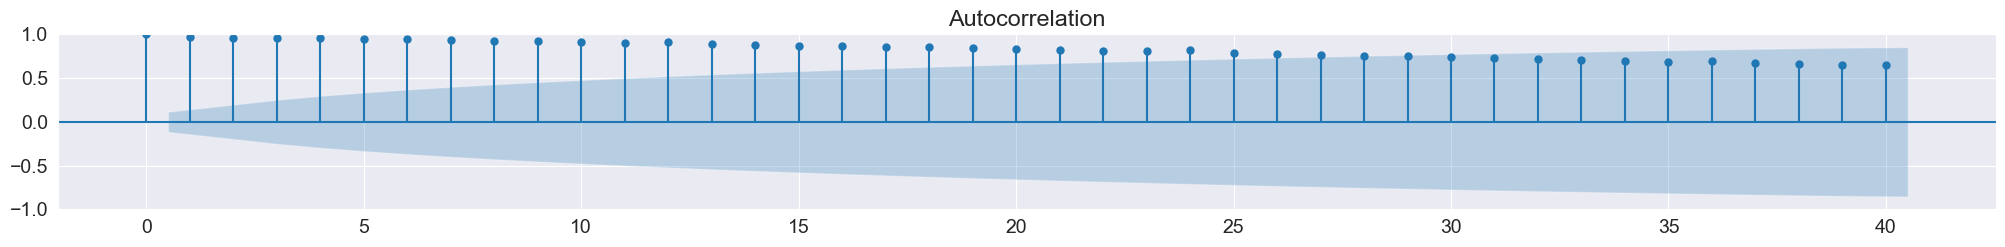

In [17]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_wage_boxcox['wage_boxcox'], lags=40, ax= ax1)

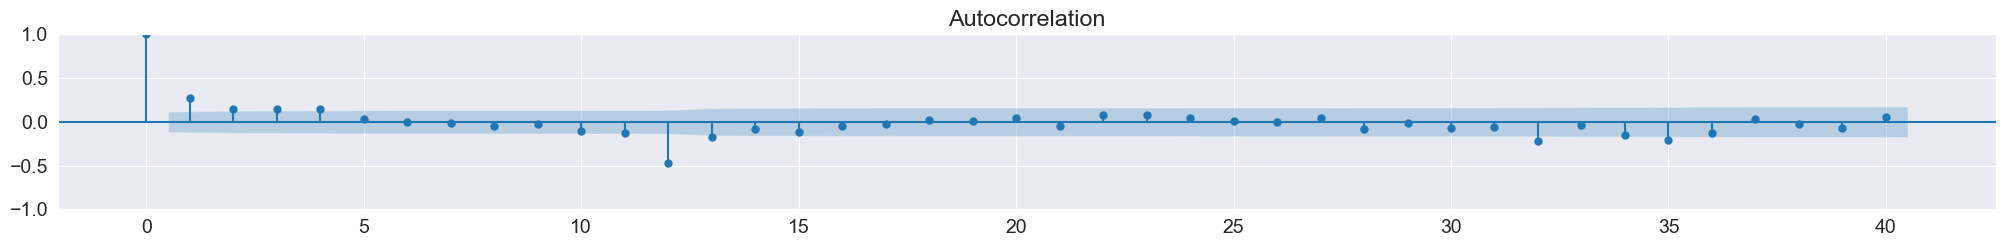

In [18]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_sdiff_ts_wage_boxcox, lags=40, ax = ax1)

**Coefficient of partial correlation:** between $y$, $x_1$ excluding dependence on $x_2$:
<img src='https://github.com/aromanenko/ATSF/blob/main/pic/PACF.PNG?raw=1'>

* <font color="red">Coefficient of partial correlation</font> shows correlation between $y_t$ and $y_{t+\tau}$, <font color=""> excluding dependence </font>
   - between $y_t$ and $y_{t+1}$ ($y_{t+\tau}$ and $y_{t+1}$)  
   - between $y_t$ and $y_{t+2}$ ($y_{t+\tau}$ and $y_{t+2}$)
   
   ...
   
   - between $y_t$ and $y_{t+\tau-1}$ ($y_{t+\tau}$ and $y_{t+\tau-1}$)


*  see here  <a href="https://timeseriesreasoning.com/contents/partial-auto-correlation"> here </a> for details

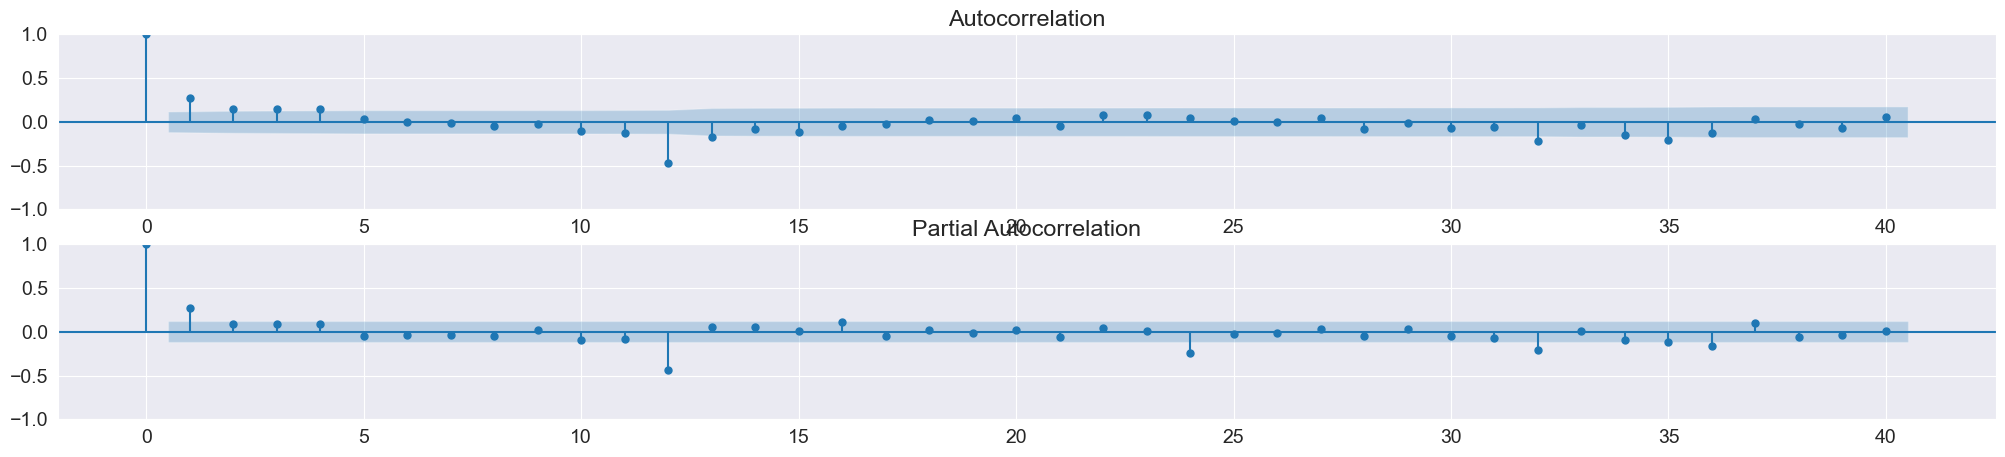

In [19]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_sdiff_ts_wage_boxcox, lags=40, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff_sdiff_ts_wage_boxcox, lags=40, ax=ax2)

**How to select candidates for $q$ and $Q$ based on ACF?**

*Answer*:
* $q$: the number of the last lag $\tau<S$ at which <span style="color:red"> ACF </span> was significant ($S$ - period of seasonality)
* $Q$: the lag numbers $\tau= s*m$ that are multiples of the seasonality period $s$: at which <span style="color:red"> ACF </span> was significant

**How to select candidates for $p$ and $P$ based on PACF?**

*Answer*:

* $p$: the number of the last lag $\tau<S$ at which <span style="color:red">PACF</span> was significant at which <span style="color:red"> PACF </span> was significant
* $P$: he lag numbers $\tau= s*m$ that are multiples of the seasonality period at which <span style="color:red">PACF</span> was significant at which <span style="color:red"> PACF </span> was significant


**Question**:
* Provide candidates for $q, Q, p, P$ values in case of the wage_ts
  * $q$ = {1, 2, 3, 4}
  * $Q$ = {1}
  * $p$ = {1}
  * $P$ = {1, 2, 3}

In [20]:
# Let's train the second ARMA model
arma_mod11 = sm.tsa.ARIMA(diff_sdiff_ts_wage_boxcox, order = (1,0, 1)).fit()
print(arma_mod11.summary())

draw_arima_forecast(pd.DataFrame(diff_sdiff_ts_wage_boxcox), arma_mod11, start_dt='2014-12-01', end_dt='2017-12-01')

                               SARIMAX Results                                
Dep. Variable:            wage_boxcox   No. Observations:                  276
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 502.552
Date:                Wed, 26 Feb 2025   AIC                           -997.104
Time:                        00:18:39   BIC                           -982.622
Sample:                    02-01-1994   HQIC                          -991.293
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.004      0.048      0.961      -0.008       0.008
ar.L1          0.6800      0.131      5.183      0.000       0.423       0.937
ma.L1         -0.4570      0.156     -2.934      0.0

In [21]:
# Let's train the second ARIMA(p,d,q)x(P, D, Q) model
arima_011_311 = sm.tsa.SARIMAX(endog = ts_wage_boxcox['wage_boxcox'], order=(0, 1, 1), seasonal_order = (3,1,1,12)).fit()
print(arima_011_311.summary())

draw_arima_forecast(ts_wage_boxcox[['wage_boxcox']], arima_011_311, start_dt='2008-01-01', end_dt='2017-12-01')

                                     SARIMAX Results                                      
Dep. Variable:                        wage_boxcox   No. Observations:                  289
Model:             SARIMAX(0, 1, 1)x(3, 1, 1, 12)   Log Likelihood                 554.845
Date:                            Wed, 26 Feb 2025   AIC                          -1097.689
Time:                                    00:18:53   BIC                          -1075.967
Sample:                                01-01-1993   HQIC                         -1088.972
                                     - 01-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1691      0.047      3.596      0.000       0.077       0.261
ar.S.L12      -0.4056      0.149   

**What else can be done?**
## Residuals Analysis
**Questions**:
* How to check all assumptions around ARIMA model?
  - Unbiasedness ($\mathbf{E}\varepsilon_t = 0$): Wilcoxon or Student.
  - No autocorrelation in residuals ($\mathbf{E}\varepsilon_t \varepsilon_{t+\tau} = 0$): correlogram analysis, Ljung-Box Q-test, Durbin-Watson.
  - Normality ($\varepsilon_t \in N(0, \sigma)$): q-q plot, Shapiro-Wilk test.
  - Stationarity ($\varepsilon_t$ belong to the same distibution $\forall t$)  visual analysis, KPSS, Dickey-Fuller.


In [22]:
arima_011_311.resid

Timestamp
1993-01-01    4.605170
1993-02-01   -0.009646
1993-03-01    0.027192
1993-04-01    0.078219
1993-05-01    0.048076
                ...   
2016-09-01   -0.004736
2016-10-01   -0.017334
2016-11-01    0.005790
2016-12-01    0.006078
2017-01-01    0.021834
Length: 289, dtype: float64

In [23]:
# plot residuals
pd.DataFrame(arima_011_311.resid).plot().update_layout(height=350, width=1300).show()

### Autocorrelation test

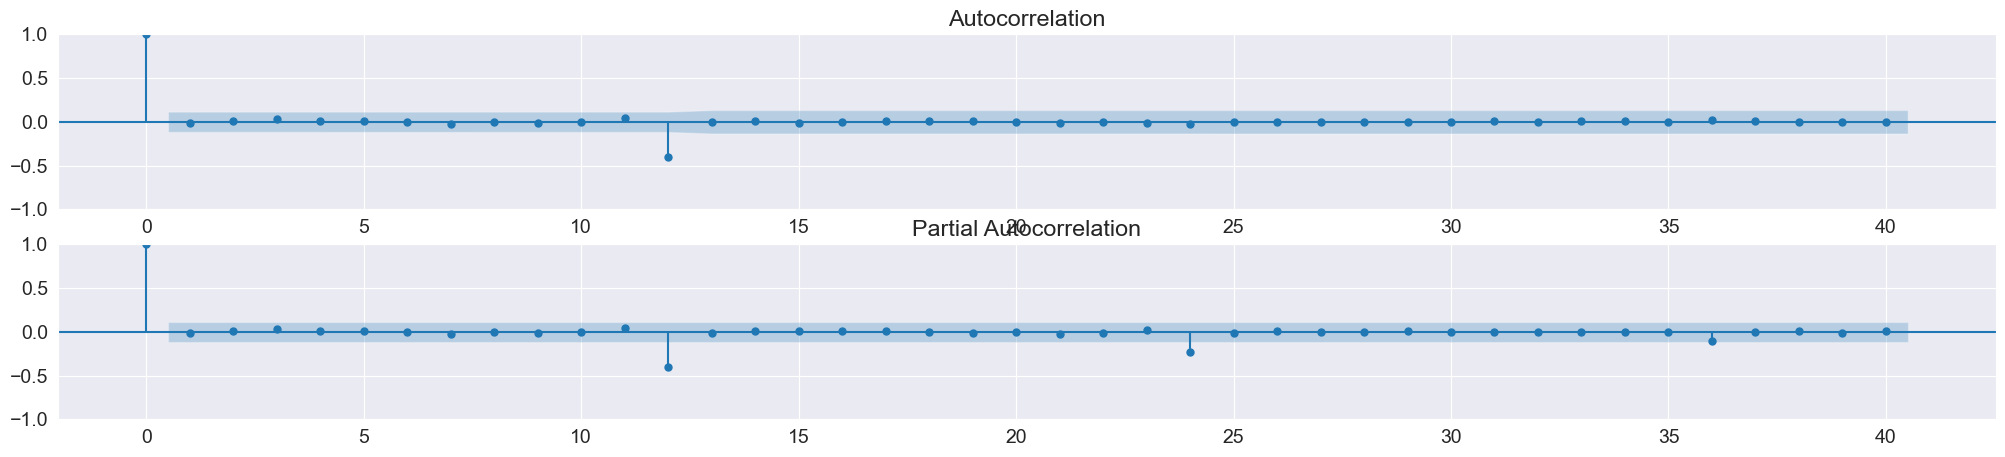

In [24]:
# Autocorrelation analysis of residuals
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_011_311.resid.values, lags=40, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_011_311.resid.values, lags=40, ax=ax2)

In [25]:
# Ljung-Box test
# H0: there is no correlcation for lag
pd.DataFrame({'lags':range(30), 'pvalue':sm.stats.diagnostic.acorr_ljungbox(arima_011_311.resid.values, lags=30)['lb_pvalue'],
              'critial':np.array([0.05]*30)}).set_index('lags').plot().update_layout(height=350, width=1300).show()

It seems that LL lags for $\tau>12$ are correlated

# ARIMA forecast for Retail Time Series

In [47]:
ts = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/retail_10ts.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Dates')
ts.index.names=['Timestamp']
ts = ts.sort_index() # sort index
# ts.head()
dta = ts[ts.columns[0]].dropna()
dta.plot().update_layout(height=350, width=1300).show()

It can be assumed that TS is stationary

**Question**
   * Select candidates for $p$ and $q$ values for ARMA model

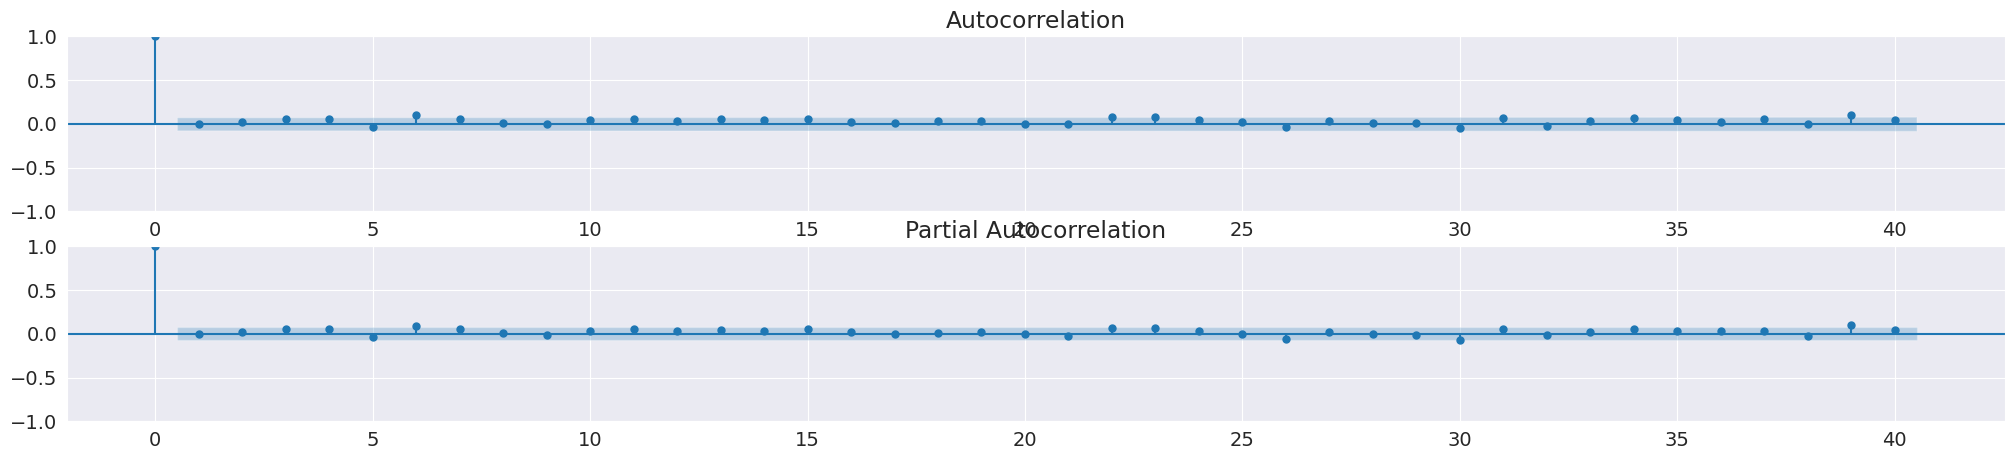

In [48]:
# Use Item 165
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta.values.squeeze(), lags=40, ax=ax2)

Let's try
* $q$ = {0, 6}
* $p$ = {0, 6}

In [49]:
# ARMA (p=0, q=0)
arma_mod00 = sm.tsa.ARIMA(dta, order=(0,0,0)).fit()
print(arma_mod00.summary())

                               SARIMAX Results                                
Dep. Variable:             Item:  165   No. Observations:                  684
Model:                          ARIMA   Log Likelihood               -1647.819
Date:                Fri, 29 Nov 2024   AIC                           3299.638
Time:                        09:04:32   BIC                           3308.694
Sample:                             0   HQIC                          3303.143
                                - 684                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9108      0.126     30.944      0.000       3.663       4.159
sigma2         7.2450      0.273     26.539      0.000       6.710       7.780
Ljung-Box (L1) (Q):                   0.04   Jarque-

In [50]:
# ARMA (p=0, q=6)
arma_mod06 = sm.tsa.ARIMA(dta, order = (0,0, 6)).fit()
print(arma_mod06.params)
print(arma_mod06.llf, arma_mod06.aic, arma_mod06.bic, arma_mod06.hqic)

const     3.916451
ma.L1    -0.014767
ma.L2     0.019733
ma.L3     0.050568
ma.L4     0.044441
ma.L5    -0.038890
ma.L6     0.099284
sigma2    7.129747
dtype: float64
-1642.3704846351181 3300.7409692702363 3336.9646326112165 3314.758476009411


In [51]:
# ARMA (p=6, q=0)
arma_mod60 = sm.tsa.ARIMA(dta, order = (6,0, 0)).fit()
print(arma_mod60.params)
print(arma_mod60.llf, arma_mod60.aic, arma_mod60.bic, arma_mod60.hqic)

const     3.917934
ar.L1    -0.006385
ar.L2     0.014421
ar.L3     0.050958
ar.L4     0.058123
ar.L5    -0.031952
ar.L6     0.094307
sigma2    7.126053
dtype: float64
-1642.204847262198 3300.409694524396 3336.633357865376 3314.4272012635706


In [52]:
# ARMA (p=6, q=6)
arma_mod66 = sm.tsa.ARIMA(dta, order = (6,0, 6)).fit()
print(arma_mod66.params)
print(arma_mod66.llf, arma_mod66.aic, arma_mod66.bic, arma_mod66.hqic)

const     3.947368
ar.L1     0.243106
ar.L2     0.202923
ar.L3     0.153840
ar.L4     0.613123
ar.L5     0.181901
ar.L6    -0.433530
ma.L1    -0.255486
ma.L2    -0.173057
ma.L3    -0.154199
ma.L4    -0.624742
ma.L5    -0.220039
ma.L6     0.515715
sigma2    6.952214
dtype: float64
-1633.3731236791368 3294.7462473582736 3358.1376582049893 3319.276884151829


### Analyse Residuals to proof the model

In [53]:
# plot residuals
arma_mod06.resid.plot().update_layout(height=350, width=1300).show()

### Stationarity test

In [54]:
# Kwiatkowski–Phillips–Schmidt–Shin
kpss_stat= stattools.kpss(arma_mod06.resid.values)
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' %
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.615316, 
pvalue: 0.02 
maximal Lag: 1 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


It can be assumed that TS is stationary

### Autocorrelation test

In [55]:
# Ljung-Box test
# H0: lags are not correlated
pd.DataFrame({'lags':range(30), 'pvalue':sm.stats.diagnostic.acorr_ljungbox(arma_mod06.resid.values, lags=30)['lb_pvalue'],
              'critial':np.array([0.05]*30)}).set_index('lags').plot().update_layout(height=350, width=1300).show()
# plt.plot(sm.stats.diagnostic.acorr_ljungbox(arma_mod00.resid.values, lags=30)[1],'b')

Values of the residuals TS are not correlated

In [56]:
# Durbin_Watson statistic
# if there is no correlation in a sample then Stat ~= 2
sm.stats.durbin_watson(arma_mod06.resid.values)

1.979968781077599

### Unbiasedness test

In [57]:
# Wilcoxon test
# H0: obervations are not biased
stat, p = stats.wilcoxon(arma_mod06.resid.values)
print('Statistic: %f\npvalue: %.2f' %(stat, p))

Statistic: 104570.000000
pvalue: 0.02


Residuals are biased!

### Normality test

In [58]:
# H0: sample comes from a normal distribution
stats.normaltest(arma_mod06.resid)

NormaltestResult(statistic=211.51491721515072, pvalue=1.1752203596622327e-46)

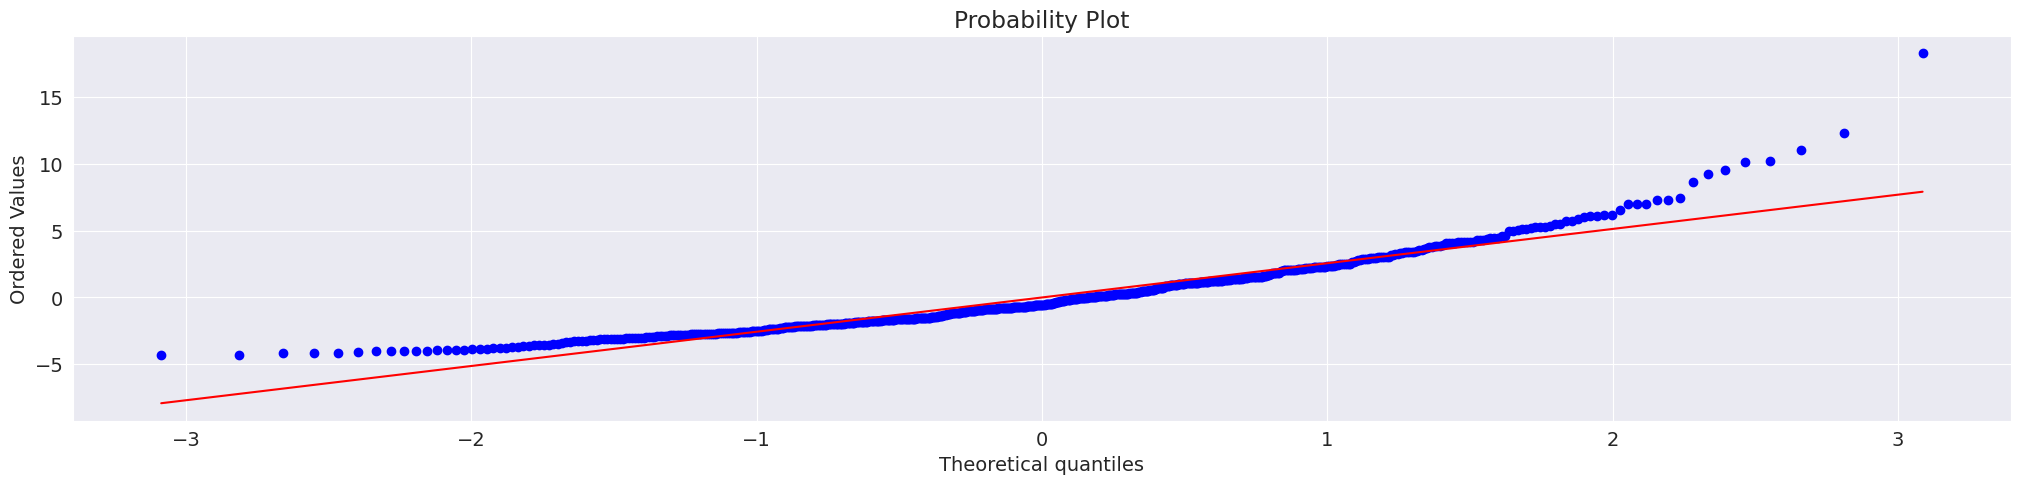

In [59]:
## q-qPlot
fig = plt.figure()
res = stats.probplot(arma_mod06.resid, dist="norm", plot = plt)

* Hypothesis of normality can be rejected because of heavy tails of the real distribution

### Forecast of Validation Period (in-sample)
Despite of theoretical issues of the built model we can generate forecast for the time series


In [60]:
# Static forecasting = one-step-ahead
# fig, ax = plt.subplots()

# fig = arma_mod06.plot_predict(start='2008-10-01', end='2008-12-31', ax=ax, dynamic=False)
# draw_arima_forecast(ts_wage_boxcox[['wage_boxcox']], arima_011_311, start_dt='2008-01-01', end_dt='2017-12-01')
draw_arima_forecast(pd.DataFrame(dta), arma_mod06) # , start_dt=pd.to_datetime('2007-01-18 00:00:00')) #, end_dt='2008-12-31')

# frc_arma = arma_mod06.predict('2008-12-30', '2008-12-31', dynamic=False)
# print(frc_arma)

### Forecast of Future Period (out-of-sample)

In [61]:
# fig, ax = plt.subplots(figsize=(25,5),  linewidth=3.0)
frc_arma = arma_mod06.forecast(steps=28) #pd.to_datetime('2009-02-01 00:00:00'))
frc_arma

,predicted_mean
684,3.683174
685,5.073314
686,4.575562
687,3.944950
688,4.901736
689,4.525140
690,3.916451
691,3.916451
692,3.916451
693,3.916451


# ACF and PACF of ARIMA models

Example1 : ACF and PACF for AR(1) model

<img src='https://github.com/aromanenko/ATSF/blob/main/pic/AR1.PNG?raw=1'>

Example2 : ACF and PACF for AR(2) model

<img src='https://github.com/aromanenko/ATSF/blob/main/pic/AR2.PNG?raw=1'>


Example3 : ACF and PACF for AR(1) and MA(1) model

<img src='https://github.com/aromanenko/ATSF/blob/main/pic/ARMA_1_1.PNG?raw=1'>



Example4 : ACF and PACF for MA(1) model

<img src='https://github.com/aromanenko/ATSF/blob/main/pic/MA2_1.PNG?raw=1'>

<!--
Example5 : ACF and PACF for MA(2) model

<img src='https://github.com/aromanenko/ATSF/blob/main/pic/MA2_2.PNG?raw=1'> -->

# Online forecasting with ARIMA
Look how (even simple) ARIMA model performs in online aprroach

In [62]:
def online_ARMA(x, h, Params): # see statsmodels.ARMA

  # Параметры алгоритма
  p = Params['p']
  q = Params['q']

  rng = pd.date_range(x.index[-1]+timedelta(1),x.index[-1]+timedelta(h))
  frc_ts = pd.Series(index = x.index.append(rng))

  for t in x.index: #
      y = deepcopy(x.loc[:t])
      if not y.dropna().empty:
          try:
              arma_mod = sm.tsa.ARIMA(y.dropna(), (p,0, q)).fit()
              frc_ts.loc[t+timedelta(h)] = arma_mod.forecast(h)[0][-1] # get last forecasting value
              # print(arma_mod.forecast(h)[0][-1])
          except Exception:
              print("Can not fit model p=%d, q=%d at step t=%s!" % (p, q, t))
  return frc_ts.ffill()

In [67]:
# Caution: takes a lot of time
p = 0
q = 6
h = 1
ts_num = 1

frc_ts = online_ARMA(x=dta, h=h, Params={'p':p, 'q': q})

Can not fit model p=0, q=6 at step t=2007-01-18 00:00:00!
Can not fit model p=0, q=6 at step t=2007-01-19 00:00:00!
Can not fit model p=0, q=6 at step t=2007-01-20 00:00:00!
Can not fit model p=0, q=6 at step t=2007-01-21 00:00:00!
Can not fit model p=0, q=6 at step t=2007-01-24 00:00:00!
Can not fit model p=0, q=6 at step t=2007-01-25 00:00:00!
Can not fit model p=0, q=6 at step t=2007-01-26 00:00:00!
Can not fit model p=0, q=6 at step t=2007-01-27 00:00:00!
Can not fit model p=0, q=6 at step t=2007-01-28 00:00:00!
Can not fit model p=0, q=6 at step t=2007-01-29 00:00:00!
Can not fit model p=0, q=6 at step t=2007-01-30 00:00:00!
Can not fit model p=0, q=6 at step t=2007-01-31 00:00:00!
Can not fit model p=0, q=6 at step t=2007-02-01 00:00:00!
Can not fit model p=0, q=6 at step t=2007-02-02 00:00:00!
Can not fit model p=0, q=6 at step t=2007-02-03 00:00:00!
Can not fit model p=0, q=6 at step t=2007-02-04 00:00:00!
Can not fit model p=0, q=6 at step t=2007-02-05 00:00:00!
Can not fit mo

In [64]:
# fair forecast by ARIMA model
plot_ts = ts[[ts.columns[ts_num]]]
# frc_ts = FRC_TS[Models[model]]
plot_ts["{0}; ARMA p={1}, q={2}".format(ts.columns[ts_num],p,q)] = frc_ts

plot_ts.plot() # :250

In [65]:
# Quality
print('MACAPE: %.2f'% qualityMAPE(plot_ts.iloc[:,0], plot_ts.iloc[:,1])[0])
print('RMSE: %.1f'% qualityRMSE(plot_ts.iloc[:,0], plot_ts.iloc[:,1])[0])

MACAPE: nan
RMSE: nan


# Conclusion
## Self-check questions
  1. How to define differencing order $d, D$ for a time series?
  2. What is autocorrelation function (ACF)?
  3. What does coefficient of correlation show?
  4. What is partial autocorrelation function (PACF)?  What does coefficient of partial correlation show?
  5. How do ACF and PACF help to choose $q, Q$ and $p, P$ of ARMA model?
   


**Materialsf**
* Автокорреляционный анализ при построении ARMA, ARIMA
    - Магнус Я.Р., Катышев П.К., Пересецкий А.А. Эконометрика. Начальный курс., глава 11
    - http://www.autobox.com/cms/index.php/blog/entry/build-or-make-your-own-arima-forecasting-model
    - А.И. Кобзарь. Прикладная математическая статистика. Для инженеров и научных работников http://zyurvas.narod.ru/knyhy2/Kobzar_Prikl_stat.djvu
* Autocorrelation analysis

  - https://online.stat.psu.edu/stat510/lesson/2

  - http://www.autobox.com/cms/index.php/blog/entry/build-or-make-your-own-arima-forecasting-model